<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/scale_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

In [7]:
# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 데이터 scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 NN (MLPClassifier)
from sklearn.neural_network import MLPClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

In [8]:
import matplotlib as mpl
# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 데이터 불러오기
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [11]:
df_raw['fur_no'] = df_raw['fur_no'].astype(str)
df_raw['fur_input_row'] = df_raw['fur_input_row'].astype(str)
# df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [12]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [13]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1144,116,1133,59,259,934,8,...,0,1,0,0,1,0,0,1,1,1
1,32,3700,15100,1144,122,1135,53,238,937,8,...,0,0,1,0,1,0,0,1,1,1
2,33,3600,19200,1129,116,1121,55,258,889,8,...,0,1,0,0,1,0,0,1,1,1


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,...,0,1,0,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,...,0,0,1,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,...,0,1,0,0,1,0,0,1,1,1


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어)


In [14]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
# df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
#                                     , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# # 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
# df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
#                                     , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

# display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,3.048596,0.141116,-1.943388,-0.860304,1.737786,-1.554930,0.402834,1.271531,-0.990555,-1.594390,...,0,0,1,1,0,0,0,1,1,0
771,-0.037866,-0.468171,-0.393299,0.368730,-0.499588,0.527104,-0.421839,-0.411992,1.328976,-0.342411,...,0,1,0,1,0,0,0,0,0,0
46,1.365071,0.547307,-1.755935,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,-1.224065,-1.594390,...,1,1,0,0,1,0,0,1,1,1
703,-0.430688,-0.265075,1.264936,0.983248,-0.651274,0.816276,-0.712900,-0.306772,1.002062,0.909569,...,1,1,0,0,1,0,0,0,1,0
457,-0.711276,0.141116,1.264936,0.416001,-0.537509,0.700607,-0.567369,-0.464602,-0.274458,0.909569,...,1,1,0,0,0,1,0,0,1,0


## 모델 생성(NN)

### 기본 옵션 모델

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
nn_uncust = MLPClassifier()
nn_uncust.fit(df_train_x_sd, df_train_y)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(nn_uncust.score(df_train_x_sd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}".format(nn_uncust.score(df_test_x_sd, df_test_y)))

Train Accuracy: 0.959
Test Accuracy: 0.884


#### Hidden Layer

In [17]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
para_hidden = [5 * hidden for hidden in range(1, 21)]  # 은닉층 노드

print(para_hidden)

for v_hidden in para_hidden:
#     nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234) # 은닉층 : 1D (5,), (10,)...
    nn = MLPClassifier(hidden_layer_sizes = (v_hidden,v_hidden)) # 은닉층 : (10,10)...
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [18]:
# 은닉층별 정확도
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,5,0.891,0.860
1,10,0.909,0.853
2,15,0.940,0.849
3,20,0.940,0.881
4,25,0.976,0.877
5,30,0.976,0.870
6,35,0.989,0.888
7,40,0.994,0.881
8,45,0.994,0.881
9,50,0.998,0.853


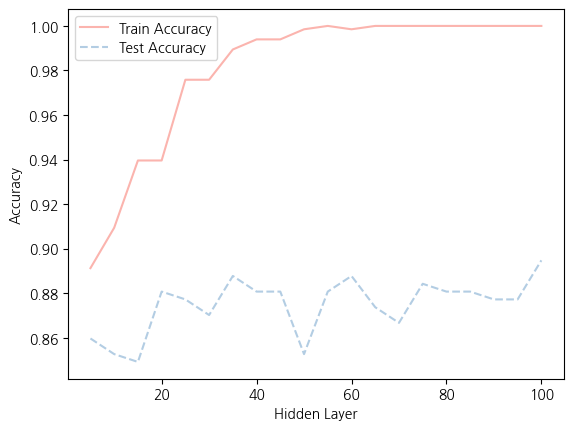

In [19]:
# 정확도 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

- Hidden Layer = 20 선택
    - 반복적으로 수행한 결과 hidden layer = 20에서 test accuracy가 꾸준히 높게 나오며
    - train accuracy와 test accuracy의 차이도 비교적 작아 overfitting 위험이 적다.

#### Activation

In [20]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# activation 변경
para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function, hidden_layer_sizes=(20,20))
#     nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,100,60), random_state = 1234) # 변경 가능
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_function = pd.DataFrame()
df_accuracy_function["ActivationFunction"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

In [21]:
# Activation Function별 정확도
df_accuracy_function.round(3)

,ActivationFunction,TrainAccuracy,TestAccuracy
0,logistic,0.885,0.860
1,tanh,0.941,0.877
2,relu,0.959,0.884


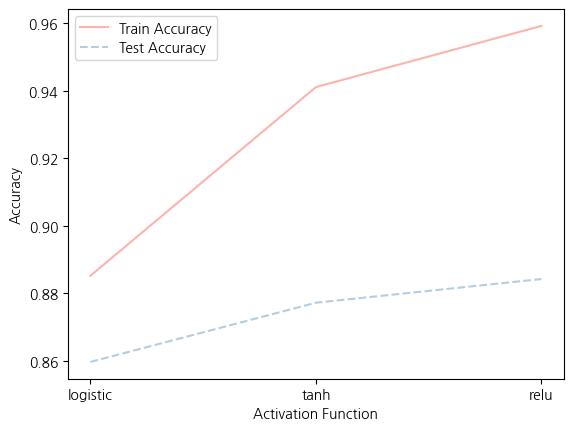

In [22]:
# 모델 정확도 그래프 확인
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Activation Function")
plt.legend()

- tanh의 test accuracy가 가장 높음

#### Solver : 가중치 최적화 변경에 따른 모델 성능

In [23]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# solver 변경
para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver = v_solver, activation="tanh", hidden_layer_sizes=(20,20))
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy

In [24]:
# Solver별 정확도 테이블
df_accuracy_solver.round(3)

,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,1.000,0.867
1,sgd,0.872,0.856
2,adam,0.937,0.884


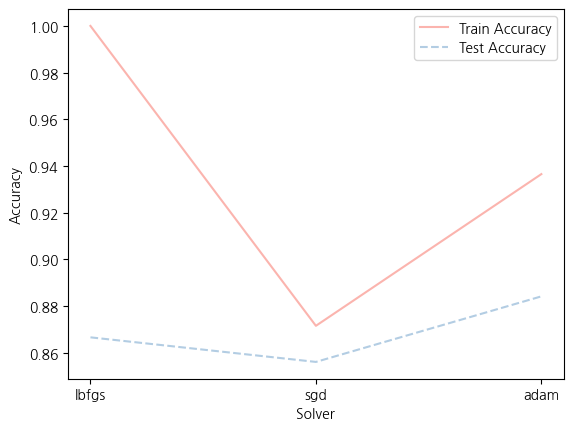

In [25]:
# 정확도 그래프 확인
plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Solver")
plt.legend()

- Solver: adam 선택
    - test accuracy는 두번째이지만
    - overfitting 위험이 적은 adam을 선택한다.

#### Mini Batch 변경에 따른 모델 성능

In [26]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# Mini Batch 변경
para_batch = [10 * batch for batch in range(1, 20)]

print(para_batch)

for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation = "tanh",
                       hidden_layer_sizes = (20,20))
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Mini Batch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


In [27]:
# Mini Batch 별 정확도
df_accuracy_batch.round(3)

,Mini Batch,TrainAccuracy,TestAccuracy
0,10,1.000,0.870
1,20,1.000,0.881
2,30,0.992,0.888
3,40,0.992,0.874
4,50,0.991,0.856
5,60,0.929,0.863
6,70,0.979,0.884
7,80,0.967,0.891
8,90,0.967,0.884
9,100,0.964,0.891


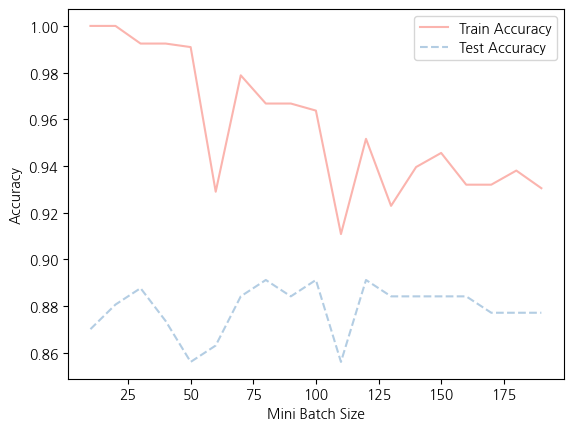

In [28]:
# 모델 정확도 그래프 확인
plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Mini Batch Size")
plt.legend()

- Mini batch size 90으로 선택

## 최종 모델 선정

In [ ]:
nn_final = MLPClassifier(batch_size = 90, solver = "adam", activation = "tanh",
                       hidden_layer_sizes = (20,20))
nn_final.fit(df_train_x_sd, df_train_y)

# 평가
y_pred = nn_final.predict(df_test_x_sd)

# train 모델 정확도
print("Train Accucary : {:.3f}".format(nn_final.score(df_train_x_sd, df_train_y)))
# test 모델 정확도
print("Test Accuracy : {:.3f}\n".format(nn_final.score(df_test_x_sd, df_test_y)))
# confusion matrix
print("Test Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accucary : 0.956
Test Accuracy : 0.877

Test Confusion Matrix: 
[[190  12]
 [ 23  60]]
              precision    recall  f1-score   support

           0      0.892     0.941     0.916       202
           1      0.833     0.723     0.774        83

    accuracy                          0.877       285
   macro avg      0.863     0.832     0.845       285
weighted avg      0.875     0.877     0.874       285



- f1-score가 1(불량) 기준 0.774로 성능이 떨어진다. 또한 train accuracy와 test accuracy의 차이가 과적합이 우려된다.